In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'castellucci_mouse_usv_segmented'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'mouse.pickle'

In [8]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [9]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,rate,spectrogram
0,22.666,22.678,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,23.804,23.818,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,23.892,23.902,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [10]:
np.shape(syllable_df.spectrogram.values[0])

(32, 20)

### project

In [11]:
ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'full')

(8302, 640)


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  if __name__ == '__main__':
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  # Remove the CWD from sys.path while we load stuff.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


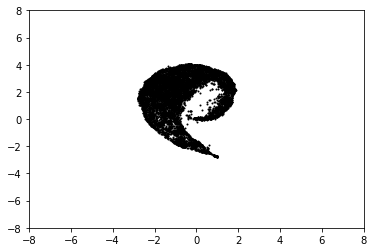

(4101, 640)


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  if __name__ == '__main__':
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  # Remove the CWD from sys.path while we load stuff.


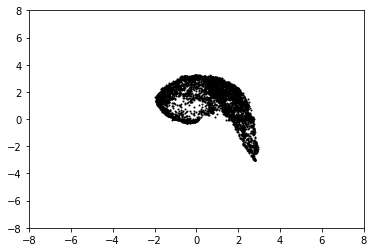

(7856, 640)


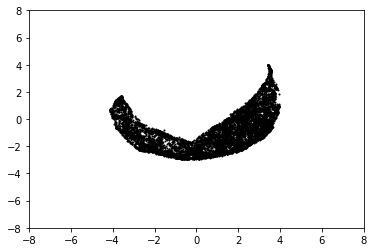

(1575, 640)


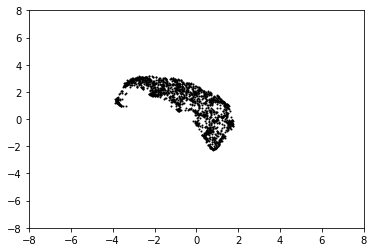

In [12]:
for indv in tqdm(syllable_df.indv.unique()):
    subset_df = syllable_df[syllable_df.indv == indv]
    
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in tqdm(specs)]
    specs_flattened = flatten_spectrograms(specs)
    print(np.shape(specs_flattened))
    
    cuml_umap = cumlUMAP()
    embedding = cuml_umap.fit_transform(specs_flattened)
    subset_df['umap'] = list(embedding)
    
    fig, ax = plt.subplots()
    ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 1)
    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    plt.show()
    
    subset_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / (indv + '.pickle'))